# **Phát hiện bất thường trong gian lận thẻ tín dụng.**

Mục đích của dự án này là dự đoán liệu một giao dịch nhất định có phải là gian lận hay không. Trong trường hợp này sẽ sử dụng các kỹ thuật phát hiện các điểm ngoại lai, bất thường như Isolation Forest, Local Outlier Factor(LOF) và  Support Vector Machine (OneClassSVM).

Bộ dữ liệu:

Tập dữ liệu được sử dụng để phát hiện gian lận thẻ tín dụng có nguồn gốc từ Kaggle.

Bộ dữ liệu chứa các giao dịch được thực hiện bằng thẻ tín dụng trong hai ngày vào năm 2013 bởi các chủ thẻ ở Châu Âu. Có 492 vụ lừa đảo trong tổng số 284.807 giao dịch.

Thuộc tính:

- V1, V2, … V28 là các thuộc tính liên quan có được với việc giảm kích thước PCA nhằm bảo vệ danh tính người dùng.

- Amount: số tiền giao dịch bằng đô la $

- Time: Tính bằng số giây trôi qua của mỗi giao dịch đối với giao dịch đầu tiên trong tập dữ liệu.

- Class: Có giá trị là 1 nếu đó là gian lận thẻ tín dụng, và 0 cho thẻ bình thường (Không gian lận thẻ tính dụng)

### **Import libriaries and data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from numpy import quantile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import linear_model
from sklearn.linear_model import SGDOneClassSVM

from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix,f1_score

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data Mining/dataset/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**First observations:**

In [4]:
#shape of data
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Kiểm tra giá trị bị thiếu trong tập dữ liệu:


In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### **Exploratory Data Analysis**


In [8]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
df_fraud = df[df["Class"]==1]
df_normal = df[df["Class"]==0]

In [9]:
outlier_fraction = len(df_fraud)/float(len(df_normal))

In [10]:
print(outlier_fraction)
print("Fraud Cases : {}".format(len(df_fraud)))
print("Normal Cases : {}".format(len(df_normal)))

0.0017304750013189597
Fraud Cases : 492
Normal Cases : 284315


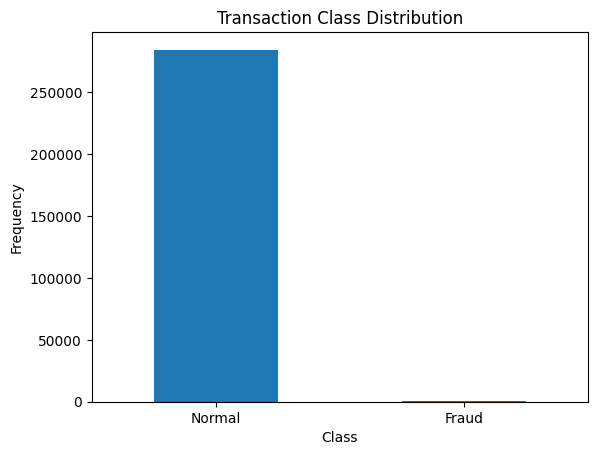

In [12]:
classes = pd.value_counts(df['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), labels = ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency");

Có 284.315 giao dịch thông thường và 492 giao dịch gian lận. Các trường hợp gian lận chỉ chiếm 0,172% trong tất cả các giao dịch. Chúng ta thấy được tập dữ liệu rất không cân bằng.




In [11]:
df[['Class', 'Amount', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5']].describe()

,Class,Amount,Time,V1,V2,V3,V4,V5
count,284807.000000,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,0.001727,88.349619,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16
std,0.041527,250.120109,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00
min,0.000000,0.000000,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02
25%,0.000000,5.600000,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01
50%,0.000000,22.000000,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02
75%,0.000000,77.165000,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01
max,1.000000,25691.160000,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01


**Transaction time**




In [ ]:
df['Time'] = df['Time'].apply(lambda x : x / 3600)

C:\Users\PC\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


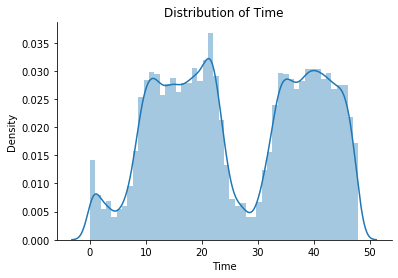

In [ ]:
sns.distplot(df['Time'])
plt.title("Distribution of Time")
sns.despine();

#### **Analysis of the Transaction Amount Data**


In [13]:
print(df_normal.Amount.describe())
print('----------------')
print(df_fraud.Amount.describe())

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
----------------
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


**Transaction by Amount Data**



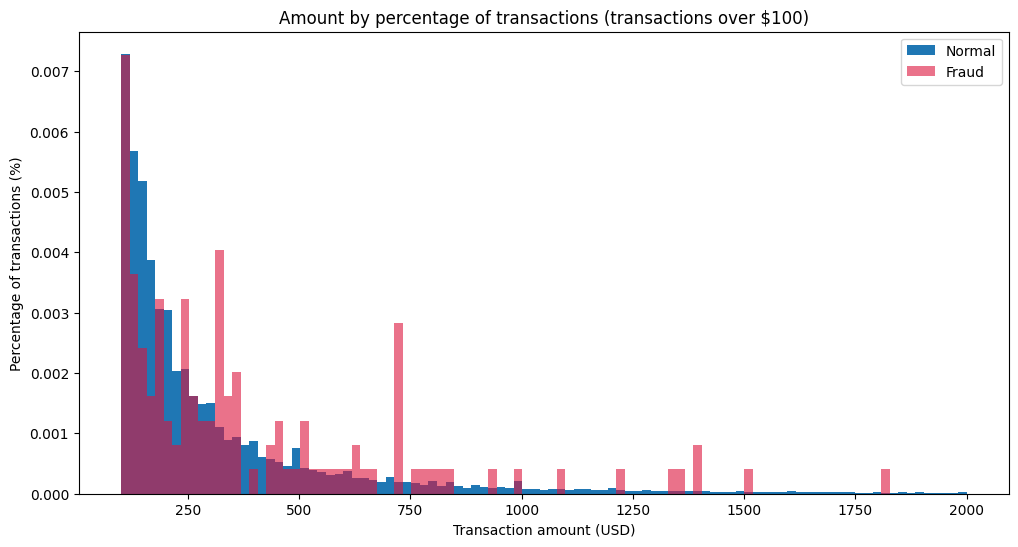

In [14]:
bins = np.linspace(100, 2000, 100)
plt.figure(figsize=(12, 6))
plt.hist(df_normal.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(df_fraud.Amount, bins, alpha=0.6, density=True, label='Fraud', color='crimson')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions over \$100)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

Sau khi trực quan hóa, ta chỉ thấy một giao dịch gian lận duy nhất. Nên sẽ khó có thể phân biệt gian lận với các giao dịch thông thường chỉ bằng số tiền giao dịch.



**Visual Exploration of Transaction Amount vs. Hour**

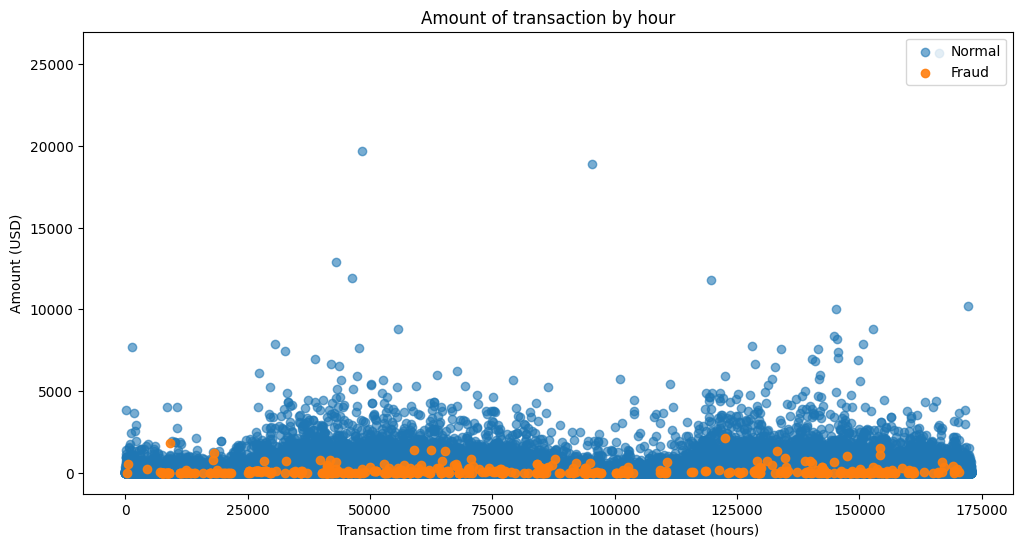

In [18]:
plt.figure(figsize=(12, 6))
plt.scatter(df_normal.Time, df_normal.Amount, alpha=0.6, label='Normal')
plt.scatter(df_fraud.Time, df_fraud.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [19]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

print(df.head())

       Time        V1        V2        V3        V4        V5        V6  \
0 -1.996583 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -1.996583  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -1.996562 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -1.996562 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -1.996541 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28    Amount  Class  
0  0.12

**Split dataset into train and test dataset**



In [20]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

In [21]:
X_train = train[train['Class'] == 0]
X_train = X_train.drop(['Class'], axis=1)

X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

In [22]:
print(f'X_train shape: {X_train.shape};')
print(f'X_test shape: {X_test.shape}; y_test shape: {y_test.shape}')

X_train shape: (199008, 30);
X_test shape: (85443, 30); y_test shape: (85443,)


### **Build models**

**1. Isolation Forest Algorithm:**

Isolation Forest là một thuật toán phát hiện bất thường không giám sát, sử dụng thuật toán Random Forest (Decision Tree) để phát hiện các ngoại lệ trong tập dữ liệu. Thuật toán cố gắng phân chia các điểm dữ liệu sao cho mỗi quan sát được tách biệt khỏi các quan sát khác.

In [ ]:
model_iF = IsolationForest(n_estimators=20, max_samples='auto', contamination=0.01, random_state=42, verbose=2)
model_iF.fit(X_train)

In [25]:
y_pred = model_iF.predict(X_test)
print(y_pred)

[-1  1  1 ...  1  1  1]


Chuyển đổi lại các giá trị dự đoán thành 0 cho các giao dịch hợp lệ và 1 cho các giao dịch gian lận:

In [26]:
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [27]:
print("Accuracy Score :")
print(accuracy_score(y_test, y_pred))
print("Classification Report :")
print(classification_report(y_test, y_pred))

Accuracy Score :
0.9894666619851831
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.10      0.69      0.17       136

    accuracy                           0.99     85443
   macro avg       0.55      0.84      0.58     85443
weighted avg       1.00      0.99      0.99     85443



F1 score:

In [28]:
f1_score(y_test, y_pred)

0.17279411764705882

**2. Local Outlier Factor**

Local Outlier Factor (LOF) đánh giá mức độ "bất thường" của mỗi điểm dữ liệu bằng cách so sánh mật độ của vùng lân cận của nó với mật độ của các vùng lân cận của các điểm xung quanh.Các điểm dữ liệu có mật độ thấp so với các điểm xung quanh được coi là outlier.


In [29]:
model_lf = LocalOutlierFactor(n_neighbors=2, contamination=0.1)
model_lf.fit(X_train)

LocalOutlierFactor(contamination=0.1, n_neighbors=2)

Predictions:

In [31]:
pred_y = model_lf.fit_predict(X_test)

scores_pred = model_lf.negative_outlier_factor_

In [32]:
scores_pred

array([-0.98227553, -1.33328636, -1.15212807, ..., -1.65366799,
       -1.07041151, -0.95327937])

In this step we obtain the threshold value from the scores by using the quantile function.  We will get the lowest 3 percent of score values as the anomalies.

In [33]:
thresh = quantile(scores_pred, .03)
print(thresh)

-2.2718693183032466


In [34]:
pred_y[pred_y == 1] = 0
pred_y[pred_y == -1] = 1

In [35]:
print("Accuracy Score :")
print(accuracy_score(y_test, pred_y))
print("Classification Report :")
print(classification_report(y_test, pred_y))

Accuracy Score :
0.898587362335124
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85307
           1       0.00      0.06      0.00       136

    accuracy                           0.90     85443
   macro avg       0.50      0.48      0.47     85443
weighted avg       1.00      0.90      0.95     85443



**3. One Class SVM (SGD):**

The SVM is an algorithm which tries to find a hyperplane that best separates the two classes of data points. For one-class SVM there are one class of data points, and their task is to predict a hypersphere that separates the cluster of data points from the anomalies. The One-class SVM with SGD solves the linear One-Class SVM using Stochastic Gradient Descent and that model we will use for our problem.


In [36]:
model_sgd = SGDOneClassSVM(random_state=42, nu = 0.1, fit_intercept=True, shuffle=True, tol=1e-4)
model_sgd.fit(X_train)

SGDOneClassSVM(nu=0.1, random_state=42, tol=0.0001)

In [37]:
pred = model_sgd.predict(X_test)

In [38]:
pred[pred == 1] = 0
pred[pred == -1] = 1

In [39]:
print("Accuracy Score :")
print(accuracy_score(y_test, pred))
print("Classification Report :")
print(classification_report(y_test, pred))

Accuracy Score :
0.9470407172032818
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     85307
           1       0.00      0.04      0.00       136

    accuracy                           0.95     85443
   macro avg       0.50      0.50      0.49     85443
weighted avg       1.00      0.95      0.97     85443

